In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-eligible-dataset/loan-train.csv
/kaggle/input/loan-eligible-dataset/loan-test.csv


# Import Laibraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import os
import scipy
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load the data

In [3]:
df = pd.read_csv("/kaggle/input/loan-eligible-dataset/loan-train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# EDA

In [4]:
print(df.shape)

(614, 13)


In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<AxesSubplot:>

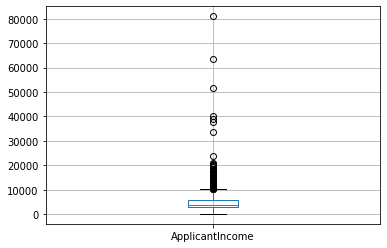

In [8]:
df.boxplot(column='ApplicantIncome')

<AxesSubplot:>

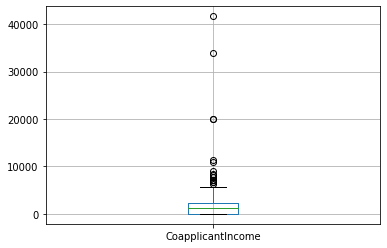

In [9]:
df.boxplot(column='CoapplicantIncome')

<AxesSubplot:>

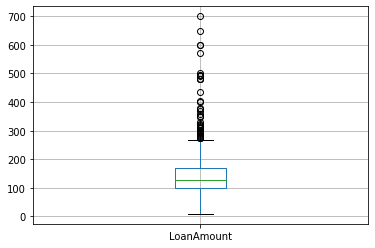

In [10]:
df.boxplot(column='LoanAmount')

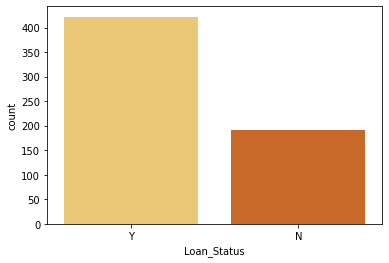

In [11]:
sns.countplot(x="Loan_Status", data=df, palette="YlOrBr")
plt.show()

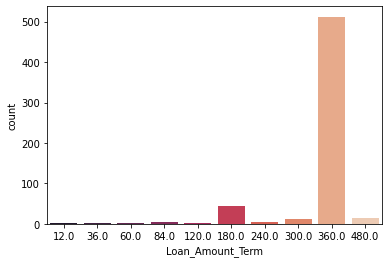

In [12]:
sns.countplot(x="Loan_Amount_Term", data=df, palette="rocket")
plt.show()

In [13]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


In [14]:
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)
df['Loan_Status'].fillna(df['Loan_Status'].mode()[0],inplace=True)

In [15]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)

In [16]:
df.Loan_Status = df.Loan_Status.replace({"Y": 1, "N" : 0})
# df.Loan_Status = df.Loan_Status.replace({"Y": 1, "N" : 0}) 

df.Gender = df.Gender.replace({"Male": 1, "Female" : 0})

df.Married = df.Married.replace({"Yes": 1, "No" : 0})

df.Self_Employed = df.Self_Employed.replace({"Yes": 1, "No" : 0})

In [17]:
from sklearn.preprocessing import LabelEncoder
feature_col = ['Property_Area','Education', 'Dependents']
le = LabelEncoder()
for col in feature_col:
    df[col] = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])

In [18]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


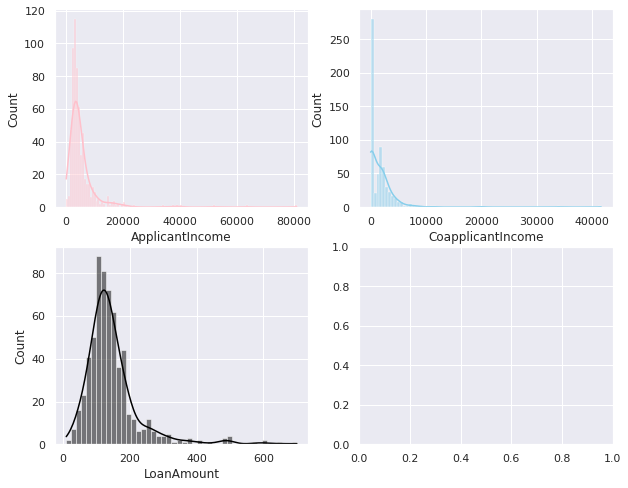

In [19]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='pink')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='black');

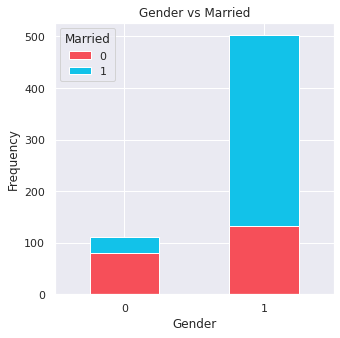

In [20]:
pd.crosstab(df.Gender,df.Married).plot(kind="bar", stacked=True, figsize=(5,5), color=['#f64f59','#12c2e9'])
plt.title('Gender vs Married')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

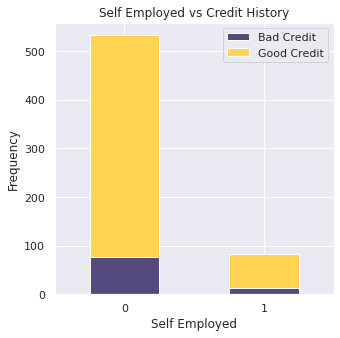

In [21]:
pd.crosstab(df.Self_Employed,df.Credit_History).plot(kind="bar", stacked=True, figsize=(5,5), color=['#544a7d','#ffd452'])
plt.title('Self Employed vs Credit History')
plt.xlabel('Self Employed')
plt.ylabel('Frequency')
plt.legend(["Bad Credit", "Good Credit"])
plt.xticks(rotation=0)
plt.show()

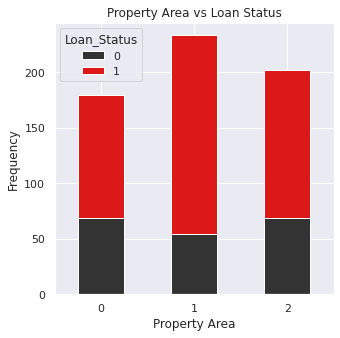

In [22]:
pd.crosstab(df.Property_Area,df.Loan_Status).plot(kind="bar", stacked=True, figsize=(5,5), color=['#333333','#dd1818'])
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

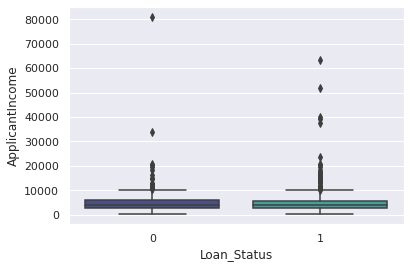

In [23]:
sns.boxplot(x="Loan_Status", y="ApplicantIncome", data=df, palette="mako");

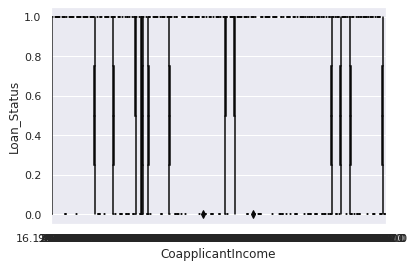

In [24]:
sns.boxplot(x="CoapplicantIncome", y="Loan_Status", data=df, palette="rocket");

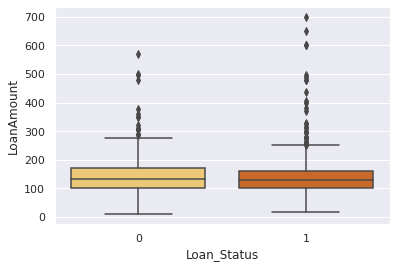

In [25]:
sns.boxplot(x="Loan_Status", y="LoanAmount", data=df, palette="YlOrBr");

In [26]:
# Square Root Transformation

df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

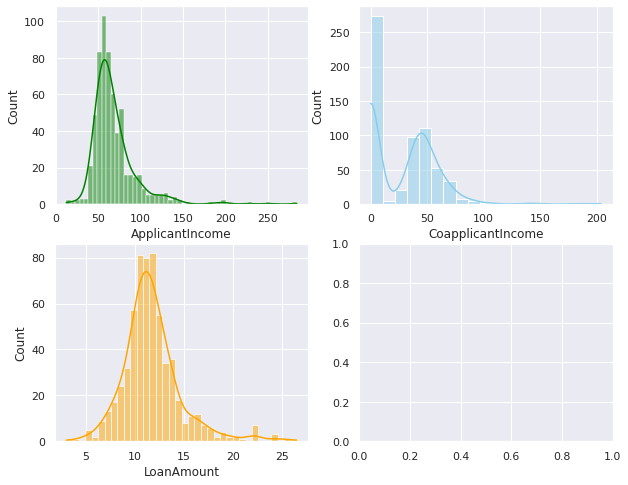

In [27]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

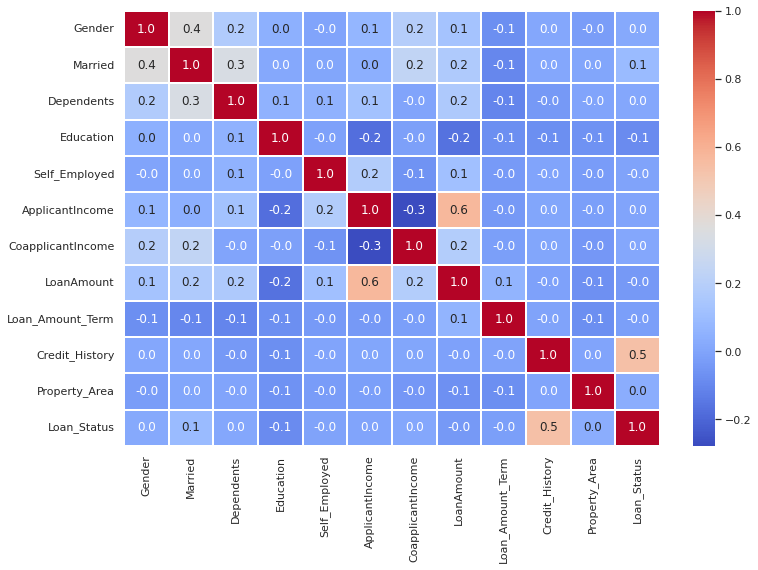

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()

In [29]:
df = df.drop(['Loan_ID'], axis = 1)

In [30]:
df = df.drop(['Property_Area'], axis = 1)

In [31]:
df = df.drop(['Loan_Amount_Term'], axis = 1)

In [32]:
df = df.drop(['LoanAmount'], axis = 1)

In [33]:
df = df.drop(['ApplicantIncome'], axis = 1)

In [34]:
df = df.drop(['Self_Employed'], axis = 1)

In [35]:
df = df.drop(['Dependents'], axis = 1)

In [36]:
df = df.drop(['Gender'], axis = 1)

In [37]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [38]:
X,y = SMOTE().fit_resample(X,y)

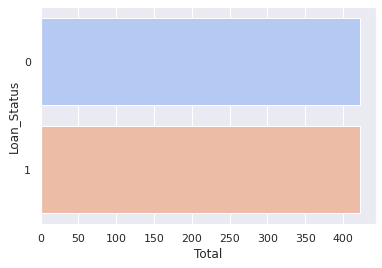

In [39]:
sns.set_theme(style="darkgrid")
sns.countplot(y=y, data=df, palette="coolwarm")
plt.ylabel('Loan_Status')
plt.xlabel('Total')
plt.show()

In [40]:
df.head()

,Married,Education,CoapplicantIncome,Credit_History,Loan_Status
0,0,0,0.000000,1.0,1
1,1,0,38.832976,1.0,0
2,1,0,0.000000,1.0,1
3,1,1,48.559242,1.0,1
4,0,0,0.000000,1.0,1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Married            614 non-null    int64  
 1   Education          614 non-null    int64  
 2   CoapplicantIncome  614 non-null    float64
 3   Credit_History     614 non-null    float64
 4   Loan_Status        614 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 24.1 KB


In [42]:
df.count()

Married              614
Education            614
CoapplicantIncome    614
Credit_History       614
Loan_Status          614
dtype: int64

In [43]:
X = MinMaxScaler().fit_transform(X)

In [44]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier      # KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier                       # XGBoost

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit, GridSearchCV

In [45]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [46]:

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

**The data set will be split into 80% train and 20% test.**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [48]:
X_train.shape

(675, 4)

In [49]:
X_test.shape

(169, 4)

In [50]:
pd.DataFrame(X_train).to_csv("X_train.csv")

In [51]:
pd.DataFrame(X_test).to_csv("X_test.csv")

In [52]:
LRclassifier = LogisticRegression(solver='saga', max_iter=500, random_state=1)
LRclassifier.fit(X_train, y_train)

LRy_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, LRy_pred))
print(confusion_matrix(y_test, LRy_pred))

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_test, LRy_pred)
print('LR accuracy: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.97      0.45      0.62        86
           1       0.64      0.99      0.77        83

    accuracy                           0.72       169
   macro avg       0.81      0.72      0.70       169
weighted avg       0.81      0.72      0.69       169

[[39 47]
 [ 1 82]]
LR accuracy: 71.60%


In [53]:
import sklearn.metrics
import math
def matrix_metrix(y_test, LRy_pred,beta):
   CM = confusion_matrix(y_test, LRy_pred)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Prevalence = round( (TP+FP) / Population,2)
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   check_Pos  = Precision + FDR
   check_Neg  = NPV + FOR
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 
   check_Pos2 = Recall + FNR
   check_Neg2 = FPR + TNR
   LRPos      = round( Recall/FPR,4 ) 
   LRNeg      = round( FNR / TNR ,4 )
   DOR        = round( LRPos/LRNeg)
   F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)

   MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
   BM         = Recall+TNR-1
   MK         = Precision+NPV-1
   MEA        = mean_squared_error(y_test, LRy_pred)
   mat_met = pd.DataFrame({
'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','MCC','BM','MK','MEA'],     'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,MCC,BM,MK,MEA]})
   return (mat_met)

In [54]:
beta = 0.4
mat_met = matrix_metrix(y_test, LRy_pred,beta)
print (mat_met)

        Metric      Value
0           TP  82.000000
1           TN  39.000000
2           FP  47.000000
3           FN   1.000000
4   Prevalence   0.760000
5     Accuracy   0.716000
6    Precision   0.635700
7          NPV   0.975000
8          FDR   0.364300
9          FOR   0.025000
10   check_Pos   1.000000
11   check_Neg   1.000000
12      Recall   0.988000
13         FPR   0.546500
14         FNR   0.012000
15         TNR   0.453500
16  check_Pos2   1.000000
17  check_Neg2   1.000000
18         LR+   1.807900
19         LR-   0.026500
20         DOR  68.000000
21          F1   0.773600
22         MCC   0.519200
23          BM   0.441500
24          MK   0.610700
25         MEA   0.284024


[[39 47]
 [ 1 82]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

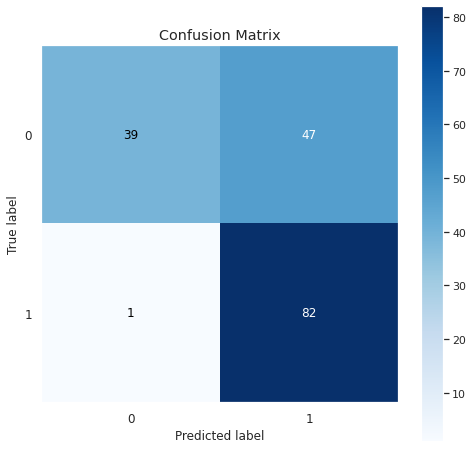

In [55]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
print(confusion_matrix(y_test, LRy_pred))
skplt.metrics.plot_confusion_matrix(y_test, LRy_pred,figsize=(8,8))

AUC: 0.721


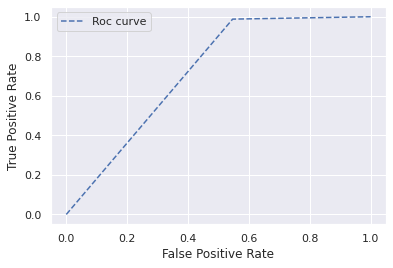

In [56]:
#ROC Implementation
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
fpr, tpr, thresholds = roc_curve(y_test,LRy_pred)
auc = roc_auc_score(y_test,LRy_pred)
print('AUC: %.3f' % auc)
pyplot.plot(fpr, tpr, linestyle='--', label='Roc curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

              precision    recall  f1-score   support

           0       0.72      0.73      0.72        86
           1       0.72      0.70      0.71        83

    accuracy                           0.72       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.72      0.72      0.72       169

              precision    recall  f1-score   support

           0       0.66      0.78      0.71        86
           1       0.72      0.58      0.64        83

    accuracy                           0.68       169
   macro avg       0.69      0.68      0.68       169
weighted avg       0.69      0.68      0.68       169

              precision    recall  f1-score   support

           0       0.72      0.71      0.71        86
           1       0.70      0.71      0.71        83

    accuracy                           0.71       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.71      0.71      0.71       169

              preci

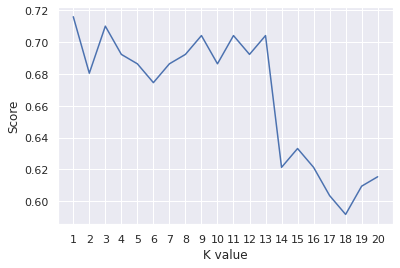

KNN best accuracy: 71.60%


In [57]:
scoreListknn = []
for i in range(1,21):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, y_train)
    scoreListknn.append(KNclassifier.score(X_test, y_test))
    KNy_pred = KNclassifier.predict(X_test)
    print(classification_report(y_test, KNy_pred))
print(confusion_matrix(y_test, KNy_pred))
plt.plot(range(1,21), scoreListknn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print("KNN best accuracy: {:.2f}%".format(KNAcc*100))

In [58]:
import sklearn.metrics
import math
def matrix_metrix(y_test, KNy_pred,beta):
   CM = confusion_matrix(y_test, KNy_pred)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Prevalence = round( (TP+FP) / Population,2)
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   check_Pos  = Precision + FDR
   check_Neg  = NPV + FOR
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 
   check_Pos2 = Recall + FNR
   check_Neg2 = FPR + TNR
   LRPos      = round( Recall/FPR,4 ) 
   LRNeg      = round( FNR / TNR ,4 )
   DOR        = round( LRPos/LRNeg)
   F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)

   MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
   BM         = Recall+TNR-1
   MK         = Precision+NPV-1
   MEA        = mean_squared_error(y_test, KNy_pred)
   mat_met = pd.DataFrame({
'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','MCC','BM','MK','MEA'],     'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,MCC,BM,MK,MEA]})
   return (mat_met)

In [59]:
beta = 0.4
mat_met = matrix_metrix(y_test, KNy_pred,beta)
print (mat_met)

        Metric      Value
0           TP  43.000000
1           TN  61.000000
2           FP  25.000000
3           FN  40.000000
4   Prevalence   0.400000
5     Accuracy   0.615400
6    Precision   0.632400
7          NPV   0.604000
8          FDR   0.367600
9          FOR   0.396000
10   check_Pos   1.000000
11   check_Neg   1.000000
12      Recall   0.518100
13         FPR   0.290700
14         FNR   0.481900
15         TNR   0.709300
16  check_Pos2   1.000000
17  check_Neg2   1.000000
18         LR+   1.782200
19         LR-   0.679400
20         DOR   3.000000
21          F1   0.569600
22         MCC   0.231800
23          BM   0.227400
24          MK   0.236400
25         MEA   0.384615


[[61 25]
 [40 43]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

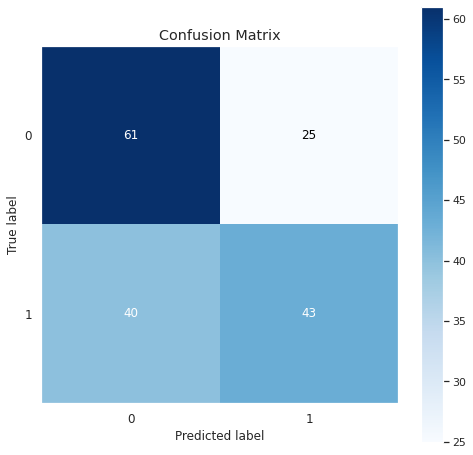

In [60]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
print(confusion_matrix(y_test, KNy_pred))
skplt.metrics.plot_confusion_matrix(y_test, KNy_pred,figsize=(8,8))

AUC: 0.614


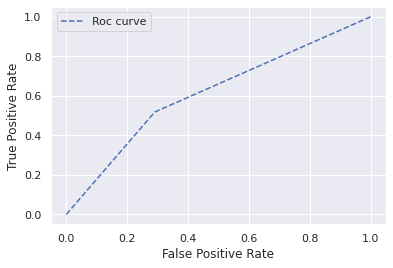

In [61]:
#ROC Implementation
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
fpr, tpr, thresholds = roc_curve(y_test,KNy_pred)
auc = roc_auc_score(y_test,KNy_pred)
print('AUC: %.3f' % auc)
pyplot.plot(fpr, tpr, linestyle='--', label='Roc curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [62]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K Neighbors'], 
                        'Accuracy': [LRAcc*100, KNAcc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Logistic Regression,71.597633
1,K Neighbors,71.597633
